#Load the Data

In [ ]:
# Import necessary libraries
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define a transform to preprocess the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize each channel of the image
])

# Download and load the training data
trainset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=transform)

# Download and load the test data
testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


#Visualize the Data

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(DataLoader(trainset, batch_size=4))
images, labels = next(dataiter)



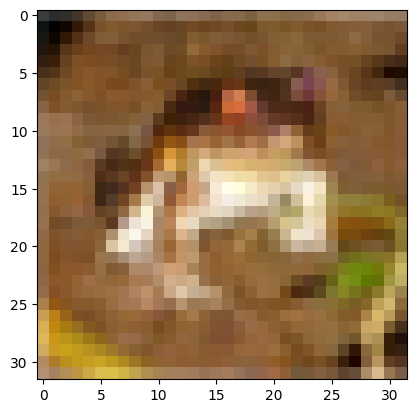

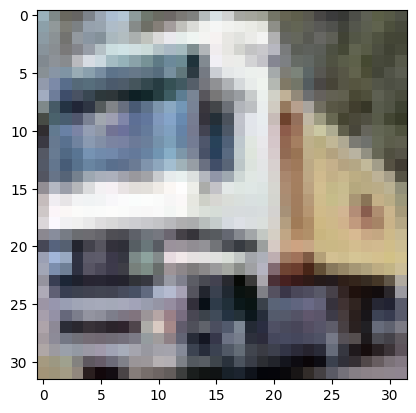

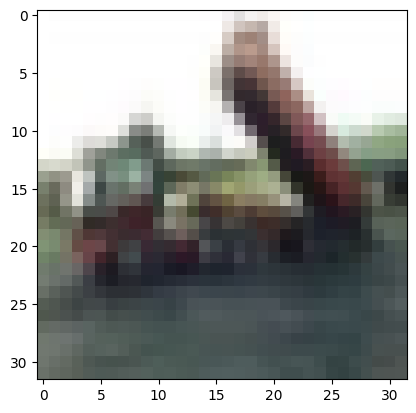

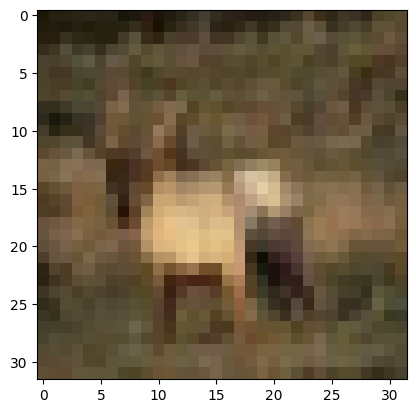

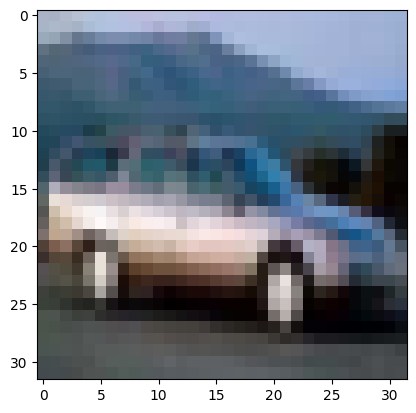

In [ ]:
for i in range(5):
  imshow(trainset[i][0])

#Analyze the Dataset

In [ ]:
# Print out some details about the dataset
print(f"Number of training images: {len(trainset)}")
print(f"Number of test images: {len(testset)}")
print(f"Image shape: {trainset[0][0].shape}")

# Analyze class distribution in the training dataset
from collections import Counter
train_labels = [label for _, label in trainset]
label_count = Counter(train_labels)
print("Training set label distribution:", label_count)


Number of training images: 50000
Number of test images: 10000
Image shape: torch.Size([3, 32, 32])
Training set label distribution: Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


#Define the Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

class CIFARNet(nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)  # Input channels = 3 for RGB images
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output classes = 10 for CIFAR-10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


#Set up Hyperparameters and Early Stopping

In [ ]:
# Hyperparameters
learning_rate = 0.001
batch_size = 64
n_epochs = 5
patience = 5  # Number of epochs to wait after last time validation loss improved.

# Initialize the network and optimizer
model = CIFARNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early stopping details
val_loss_min = np.Inf
patience_counter = 0

#Train-Validation-Test Split

In [ ]:
from torch.utils.data.dataset import random_split

# Define the size of the validation set
num_train = len(trainset)
num_valid = int(0.2 * num_train)  # Let's say we want 20% of the data for validation
num_train -= num_valid

# Split the dataset into training and validation sets
train_data, valid_data = random_split(trainset, [num_train, num_valid])


#Data Loaders

In [ ]:
# Create data loaders for the split datasets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

#Training Loop

In [ ]:
from tqdm import tqdm

# Training loop with early stopping
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    correct = 0
    total = 0

    # Training the model
    model.train()
    for idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    # Validating the model
    model.eval()
    with torch.no_grad():
        for idx, (data, target) in enumerate(tqdm(valid_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    accuracy = 100. * correct / total

    # Print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.2f}%'.format(
        epoch, train_loss, valid_loss, accuracy))

    # Check if we should stop training early
    if valid_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        val_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        val_loss_min = valid_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'EarlyStopping counter: {patience_counter} out of {patience}')
        if patience_counter >= patience:
            print('Early stopping triggered.')
            break


100%|██████████| 157/157 [00:07<00:00, 20.97it/s]


Epoch: 1 	Training Loss: 1.615696 	Validation Loss: 1.358751 	Accuracy: 51.38%
Validation loss decreased (inf --> 1.358751).  Saving model ...


100%|██████████| 157/157 [00:05<00:00, 28.51it/s]


Epoch: 2 	Training Loss: 1.268909 	Validation Loss: 1.170075 	Accuracy: 58.09%
Validation loss decreased (1.358751 --> 1.170075).  Saving model ...


100%|██████████| 157/157 [00:06<00:00, 26.07it/s]


Epoch: 3 	Training Loss: 1.116617 	Validation Loss: 1.087541 	Accuracy: 61.65%
Validation loss decreased (1.170075 --> 1.087541).  Saving model ...


100%|██████████| 157/157 [00:05<00:00, 26.46it/s]


Epoch: 4 	Training Loss: 1.017001 	Validation Loss: 1.051177 	Accuracy: 62.51%
Validation loss decreased (1.087541 --> 1.051177).  Saving model ...


100%|██████████| 157/157 [00:05<00:00, 27.49it/s]

Epoch: 5 	Training Loss: 0.930639 	Validation Loss: 1.000692 	Accuracy: 64.63%
Validation loss decreased (1.051177 --> 1.000692).  Saving model ...


#Load the Best Model and Evaluate

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))

# Test the model
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for idx, (images, labels) in enumerate(tqdm(test_loader)):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.view_as(labels).cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

100%|██████████| 157/157 [00:06<00:00, 24.18it/s]

Accuracy of the network on the 10000 test images: 64.55%


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

       plane       0.71      0.67      0.69      1000
         car       0.78      0.74      0.76      1000
        bird       0.61      0.48      0.54      1000
         cat       0.49      0.44      0.46      1000
        deer       0.45      0.77      0.57      1000
         dog       0.58      0.49      0.53      1000
        frog       0.81      0.65      0.72      1000
       horse       0.72      0.70      0.71      1000
        ship       0.74      0.76      0.75      1000
       truck       0.70      0.76      0.73      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



Confusion matrix, without normalization
Normalized confusion matrix


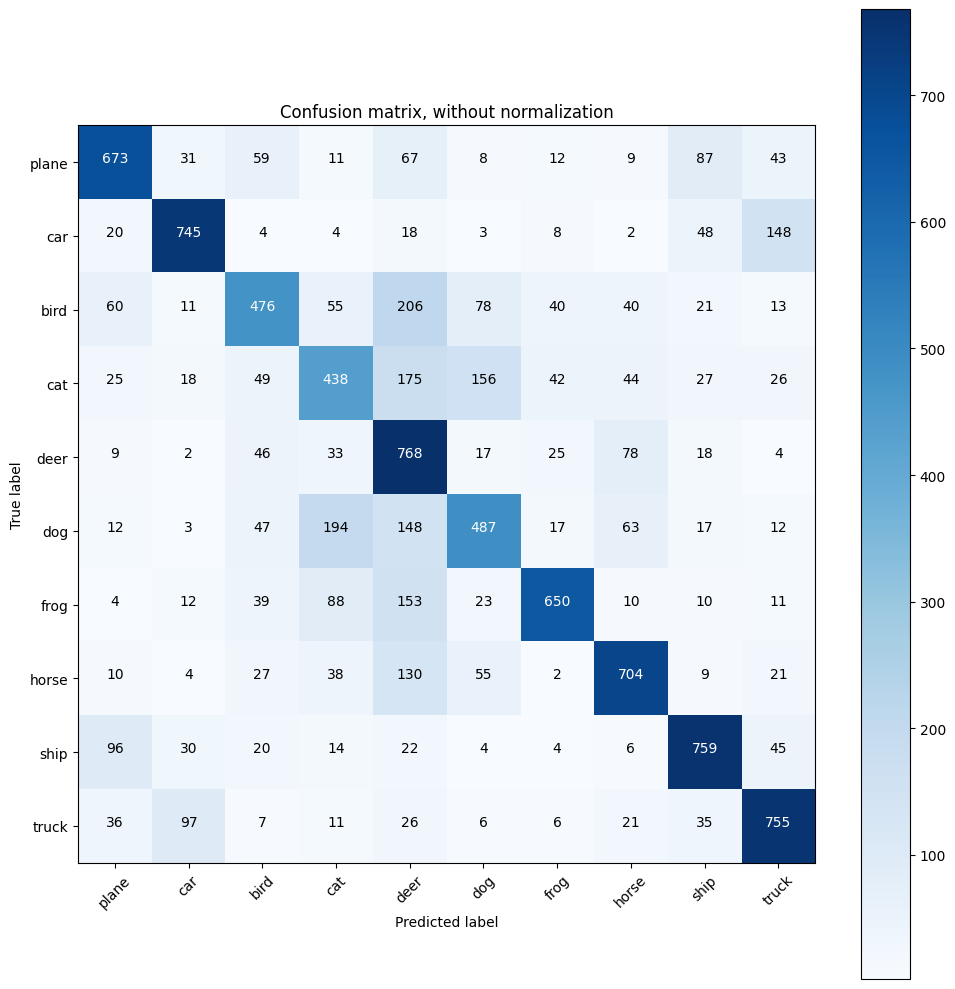

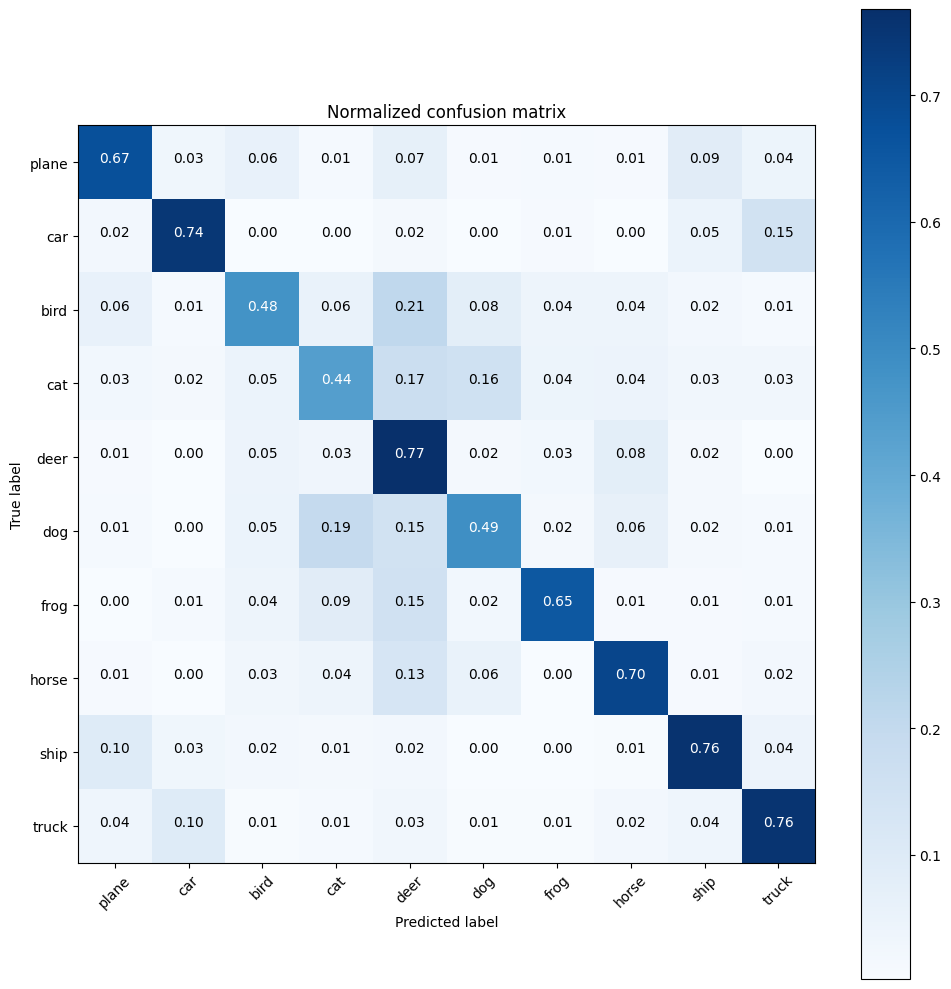

In [ ]:
import itertools

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=classes, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()